In [20]:
pip install prophet

  Using cached prophet-1.1.7-py3-none-win_amd64.whl.metadata (3.6 kB)
  Using cached cmdstanpy-1.2.5-py3-none-any.whl.metadata (4.0 kB)
  Using cached holidays-0.74-py3-none-any.whl.metadata (39 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached stanio-0.5.1-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   -- ------------------------------------- 0.8/13.3 MB 8.3 MB/s eta 0:00:02
   --- ------------------------------------ 1.3/13.3 MB 4.2 MB/s eta 0:00:03
   ------ --------------------------------- 2.1/13.3 MB 4.0 MB/s eta 0:00:03
   -------- ------------------------------- 2.9/13.3 MB 3.8 MB/s eta 0:00:03
   ---------- ----------------------------- 3.4/13.3 MB 3.6 MB/s eta 0:00:03
   ----------- ---------------------------- 3.9/13.3 MB 3.2 MB/s eta 0:00:03
   ------------ --------------------------- 4.2/13.3 MB 3.1 MB/s eta 0:00:03
   ------------- -------------------------- 4.5/13.3 

In [19]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pmdarima import auto_arima   # tiện tìm (p,d,q)(P,D,Q)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
# ────────────────────────────
# 📂 CELL 2 – Đọc file CSV
# ────────────────────────────
# Vì file .ipynb và .csv ở cùng thư mục, chỉ cần './salemate_invoice.csv'
df = pd.read_csv(
    './salemate_invoice.csv',      # hoặc r'./salemate_invoice.csv'
    encoding='utf-8',              # đổi nếu file khác mã UTF-8
)

# Xem nhanh 5 dòng đầu
df.head()

,INVOICE_ID,USERS_ID,TOTAL_AMOUNT,PAYMENT_STATUS,CREATED_AT,DETAIL_ID,PRODUCT_ID,QUANTITY,PRICE,TOTAL
0,192,7,106618.57,Unpaid,17-FEB-24,1117,156,92,71.96,6620.32
1,192,7,106618.57,Unpaid,17-FEB-24,1118,325,69,700.13,48308.97
2,192,7,106618.57,Unpaid,17-FEB-24,1119,105,84,143.99,12095.16
3,192,7,106618.57,Unpaid,17-FEB-24,1120,240,42,192.03,8065.26
4,192,7,106618.57,Unpaid,17-FEB-24,1121,173,33,955.42,31528.86


In [6]:
# ────────────────────────────
# 🛠 CELL 3 – Tiền xử lý cơ bản
# ────────────────────────────
# 1) Đảm bảo tên cột không có khoảng trắng (nếu cần):
df.columns = [c.strip().upper() for c in df.columns]

# 2) Chuyển CREATED_AT về datetime
df['CREATED_AT'] = pd.to_datetime(df['CREATED_AT'])

# 3) Lấy cột cần dùng
df = df[['PRODUCT_ID', 'CREATED_AT', 'QUANTITY']]
df.head()

C:\Users\Nhan\AppData\Local\Temp\ipykernel_17260\755490594.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CREATED_AT'] = pd.to_datetime(df['CREATED_AT'])


,PRODUCT_ID,CREATED_AT,QUANTITY
0,156,2024-02-17,92
1,325,2024-02-17,69
2,105,2024-02-17,84
3,240,2024-02-17,42
4,173,2024-02-17,33


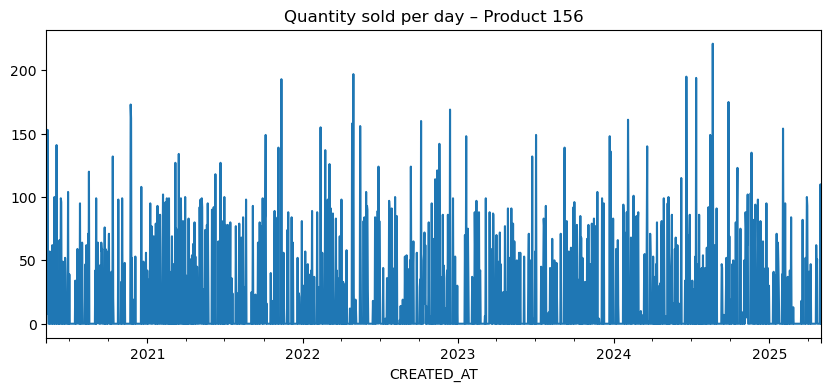

In [7]:
# ────────────────────────────
# 📊 CELL 4 – Tạo chuỗi thời gian theo từng sản phẩm
# ────────────────────────────
# Ví dụ: chọn 1 sản phẩm để demo (bạn thay 156 bằng id tùy ý)
product_id = 156
ts = (
    df[df['PRODUCT_ID'] == product_id]
      .groupby('CREATED_AT')['QUANTITY']
      .sum()
      .asfreq('D')      # tần suất ngày
      .fillna(0)        # ngày không bán => 0
)

ts.plot(title=f'Quantity sold per day – Product {product_id}', figsize=(10,4))
plt.show()

In [8]:
# ────────────────────────────
# ✂ CELL 5 – Train / Test split
# ────────────────────────────
train_size = int(len(ts) * 0.8)
train, test = ts.iloc[:train_size], ts.iloc[train_size:]
print(f"Train: {train.index[0]} → {train.index[-1]}  ({len(train)} points)")
print(f"Test : {test.index[0]} → {test.index[-1]}  ({len(test)} points)")

Train: 2020-05-09 00:00:00 → 2024-05-03 00:00:00  (1456 points)
Test : 2024-05-04 00:00:00 → 2025-05-03 00:00:00  (365 points)


In [9]:
# ────────────────────────────
# 🔍 CELL 6 – Tự tìm (p,d,q)(P,D,Q) nhanh bằng auto_arima
# ────────────────────────────
auto_model = auto_arima(
    train,
    seasonal=True,
    m=7,            # chu kỳ 7 ngày (tuần); nếu dữ liệu có seasonality 7 – bạn chỉnh thành 12, 30... tuỳ
    trace=True,
    suppress_warnings=True,
    stepwise=True,
)

print(auto_model.summary())
order, seasonal_order = auto_model.order, auto_model.seasonal_order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=14459.583, Time=3.12 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=14454.012, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=14456.757, Time=0.35 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=14456.676, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=14818.099, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=14455.908, Time=0.23 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=14455.910, Time=0.09 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=14454.828, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=14454.745, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=14450.763, Time=0.81 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=14452.792, Time=1.72 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=14458.942, Time=0.57 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=14461.242, Time=1.22 sec
 ARIMA(2,0,1)(0,0,0)[7] i

In [10]:
# ────────────────────────────
# 🏋 CELL 7 – Fit SARIMA với tham số tìm được
# ────────────────────────────
model = SARIMAX(
    train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:               QUANTITY   No. Observations:                 1456
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -7226.554
Date:                Thu, 12 Jun 2025   AIC                          14459.108
Time:                        19:19:35   BIC                          14474.954
Sample:                    05-09-2020   HQIC                         14465.020
                         - 05-03-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   4316.251      0.000       0.999       1.000
ma.L1         -0.9996      0.029    -34.466      0.000      -1.056      -0.943
sigma2      1397.4749     60.864     22.961      0.0

D:\Ancacoda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
# ────────────────────────────
# 📐 CELL 8a – Thêm nhiều metric đánh giá
# ────────────────────────────
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mape(y_true, y_pred):
    """Mean Absolute Percentage Error [%]."""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    """Symmetric MAPE [%]."""
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def mase(y_true, y_pred, seasonality=1):
    """
    Mean Absolute Scaled Error.
    seasonality=1  → chuẩn hoá theo sai số MAE của naïve forecast y(t) = y(t-1)
    """
    diff = np.abs(np.diff(y_true, n=seasonality))
    mae_naive = np.mean(diff)
    return mean_absolute_error(y_true, y_pred) / mae_naive

# y_true / y_pred từ Cell 8
y_true = test.values
y_pred = pred_mean.values

rmse = mean_squared_error(y_true, y_pred, squared=False)
mae  = mean_absolute_error(y_true, y_pred)
mape_val  = mape(y_true, y_pred)
smape_val = smape(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
mase_val = mase(y_true, y_pred)

print(f"📊 ĐÁNH GIÁ – Product {product_id}")
print(f"RMSE  = {rmse:.3f}")
print(f"MAE   = {mae:.3f}")
print(f"MAPE  = {mape_val:.2f}%")
print(f"SMAPE = {smape_val:.2f}%")
print(f"R²    = {r2:.4f}")
print(f"MASE  = {mase_val:.3f}")

📊 ĐÁNH GIÁ – Product 156
RMSE  = 36.775
MAE   = 26.506
MAPE  = inf%
SMAPE = 166.46%
R²    = -0.0038
MASE  = 0.840


D:\Ancacoda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Nhan\AppData\Local\Temp\ipykernel_17260\3125272179.py:8: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


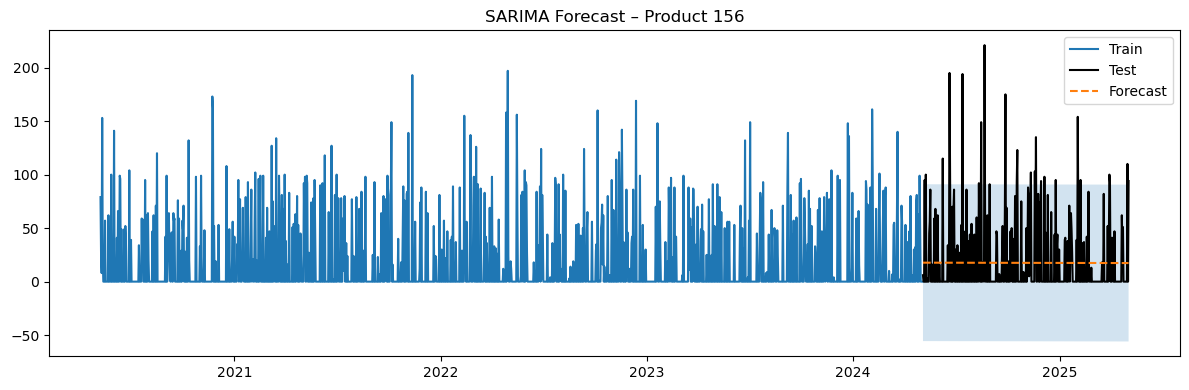

In [12]:
# ────────────────────────────
# 📈 CELL 9 – Vẽ biểu đồ thực tế vs dự báo
# ────────────────────────────
plt.figure(figsize=(12,4))
plt.plot(train, label='Train')
plt.plot(test,  label='Test',  color='black')
plt.plot(pred_mean.index, pred_mean, label='Forecast', linestyle='--')
plt.fill_between(
    pred_conf.index,
    pred_conf.iloc[:,0],
    pred_conf.iloc[:,1],
    alpha=0.2,
)
plt.legend()
plt.title(f'SARIMA Forecast – Product {product_id}')
plt.tight_layout()
plt.show()

In [15]:
# ────────────────────────────
# 🅰️ CELL 11 – ARIMA(0,1,1) baseline
# ────────────────────────────
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima011 = SARIMAX(train, order=(0,1,1)).fit()
pred_arima = arima011.get_forecast(steps=len(test)).predicted_mean

In [16]:
# ────────────────────────────
# ♨️ CELL 12 – Holt-Winters (Exponential Smoothing)
# ────────────────────────────
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# seasonal_periods=7 giả định chu kỳ tuần; chỉnh nếu khác
hw_model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=7
).fit()
pred_hw = hw_model.forecast(len(test))

In [21]:
# ────────────────────────────
# 🌟 CELL 13 – Prophet
# ────────────────────────────
from prophet import Prophet

# Prophet yêu cầu dataframe 'ds', 'y'
prophet_df = train.reset_index().rename(columns={'CREATED_AT':'ds', 'QUANTITY':'y'})
m_prophet = Prophet(daily_seasonality=True, weekly_seasonality=True)
m_prophet.fit(prophet_df)

future = m_prophet.make_future_dataframe(periods=len(test), freq='D')
forecast = m_prophet.predict(future)
pred_prophet = forecast.set_index('ds')['yhat'][-len(test):]

19:52:26 - cmdstanpy - INFO - Chain [1] start processing
19:52:27 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
# ────────────────────────────
# 📋 CELL 14 – Tính metric & so sánh
# ────────────────────────────
def metrics(y_true, y_pred):
    return {
        'RMSE' : mean_squared_error(y_true, y_pred, squared=False),
        'MAE'  : mean_absolute_error(y_true, y_pred),
        'MASE' : mase(y_true, y_pred),          # hàm mase() đã có ở Cell 8a
    }

results = pd.DataFrame({
    'SARIMA' : metrics(test, pred_mean),
    'ARIMA011': metrics(test, pred_arima),
    'HoltWin' : metrics(test, pred_hw),
    'Prophet' : metrics(test, pred_prophet),
}).T

display(results.sort_values('RMSE'))

D:\Ancacoda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
D:\Ancacoda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
D:\Ancacoda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
D:\Ancacoda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.wa

,RMSE,MAE,MASE
ARIMA011,36.733537,26.898448,0.852878
SARIMA,36.775283,26.506084,0.840437
Prophet,36.995627,26.180683,0.830119
HoltWin,40.595664,34.626838,1.097924


In [23]:
# ────────────────────────────
# 💾 CELL 15 – Lưu mô hình tốt nhất
# ────────────────────────────
import joblib, pickle, os

best_model_name = results['RMSE'].idxmin()
print("👉 BEST model:", best_model_name)

save_dir = './saved_models'
os.makedirs(save_dir, exist_ok=True)

if best_model_name == 'SARIMA':
    # statsmodels SARIMAXResults có sẵn hàm .save()
    model.save(f'{save_dir}/sarima_{product_id}.pkl')
elif best_model_name == 'ARIMA011':
    arima011.save(f'{save_dir}/arima011_{product_id}.pkl')
elif best_model_name == 'HoltWin':
    joblib.dump(hw_model, f'{save_dir}/holtwin_{product_id}.joblib')
elif best_model_name == 'Prophet':
    with open(f'{save_dir}/prophet_{product_id}.pkl', 'wb') as f:
        pickle.dump(m_prophet, f)

print("✅ Model saved to", save_dir)

👉 BEST model: ARIMA011
✅ Model saved to ./saved_models
